# Mask R-CNN
Documentation for a Mask R-CNN can be found [here](https://arxiv.org/abs/1703.06870). The work for this notebook followed this [tutorial](https://machinelearningmastery.com/how-to-train-an-object-detection-model-with-keras/). 

The base layout was taken from the tutorial, as well as the base for the plot function at the end.

The github for Mask R-CNN is originally [here](https://github.com/matterport/Mask_RCNN/) and a fork of thisfrom [here] (https://github.com/ahmedfgad/Mask-RCNN-TF2) was used due to there being various version issues that needed to be handled to get it to work properly. 

This method has its limitations in this context, especially because it isn't the best implentation for it initially. The training set is small, and how to apply it to normal tissue was not decided on. 

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split

import tensorflow as tf
import glob
from sklearn import metrics
from tensorflow.keras import utils

from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from tensorflow.keras.models import load_model
from matplotlib import pyplot
from numpy import expand_dims
from matplotlib.patches import Rectangle

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Make a file list
files = glob.glob('all-mias.tar/mdb*')

## Splitting Data

Because of how the package is setup, in function calls for the data are split into train and test. Splitting the data just by first 75% and the rest has imbalance in the testing set. Doing a train test split for file numberr improves this

In [18]:
X = list(range(len(files)))
y = list(range(len(files)))
train_i, test_i, dummy_train, dummy_test = train_test_split(X,y,random_state = 42)
print(len(train_i),len(test_i))

241 81


## Making information files

This splits the base file into an XML for all of the individual files. If the image has no tumor, then a 0 pixel bounding box was assigned.

In [3]:
#Open the data file and a temporary output file to start
f = open("all-mias.tar/Info_red.txt", "r")
f_out =  open(f'dummy.xml','w')
#Loop until we say to leave, which is when we reach EOF
prev_num = -1
while True:
    #Read in next line
    nstr = f.readline()
    #break at EOF
    if len(nstr) == 0:
        break
    #Break up the columns
    str_list = nstr.split()
    #print(str_list)
    #Get the file number
    img_id = str_list[0][3:6]
    #If new file, close last file, start a new one
    if prev_num != img_id:
        f_out.write("</annotation>")
        f_out.close()
        f_out = open(f'all-mias.tar/annot/{img_id}.xml','w')
        f_out.write(f"""<annotation>
    <folder>all-mias.tar</folder>
    <path>all-mias.tar/{str_list[0]}.pgm</path>
    <source>
        <database>Unknown</database>
    </source>
    <filename>{str_list[0]}</filename>
    <size>
        <width>1024</width>
        <height>1024</height>
        <depth>1</depth>
    </size>
    <segmented>0</segmented>
""")
    #If there is a turmor, put the infor
    if len(str_list) > 3:
        f_out.write(f"""    <object>
        <name>tumor</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
            <xmin>{int(str_list[4]) - int(str_list[6])}</xmin>
            <ymin>{1024-int(str_list[5]) - int(str_list[6])}</ymin>
            <xmax>{int(str_list[4]) + int(str_list[6])}</xmax>
            <ymax>{1024-int(str_list[5]) + int(str_list[6])}</ymax>
        </bndbox>
    </object>
""")
    #If no tumor, 0 pixel size
    else:
        f_out.write(f"""    <object>
        <name>normal</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
            <xmin>{0}</xmin>
            <ymin>{0}</ymin>
            <xmax>{0}</xmax>
            <ymax>{0}</ymax>
        </bndbox>
    </object>
""")
    prev_num = img_id
    
#Close the last file
f_out.write("</annotation>")
f_out.close()


['mdb001', 'G', 'CIRC', 'B', '535', '425', '197']
['mdb002', 'G', 'CIRC', 'B', '522', '280', '69']
['mdb003', 'D', 'NORM']
['mdb004', 'D', 'NORM']
['mdb005', 'F', 'CIRC', 'B', '477', '133', '30']
['mdb005', 'F', 'CIRC', 'B', '500', '168', '26']
['mdb006', 'F', 'NORM']
['mdb007', 'G', 'NORM']
['mdb008', 'G', 'NORM']
['mdb009', 'F', 'NORM']
['mdb010', 'F', 'CIRC', 'B', '525', '425', '33']
['mdb011', 'F', 'NORM']
['mdb012', 'F', 'CIRC', 'B', '471', '458', '40']
['mdb013', 'G', 'MISC', 'B', '667', '365', '31']
['mdb014', 'G', 'NORM']
['mdb015', 'G', 'CIRC', 'B', '595', '864', '68']
['mdb016', 'G', 'NORM']
['mdb017', 'G', 'CIRC', 'B', '547', '573', '48']
['mdb018', 'G', 'NORM']
['mdb019', 'G', 'CIRC', 'B', '653', '477', '49']
['mdb020', 'G', 'NORM']
['mdb021', 'G', 'CIRC', 'B', '493', '125', '49']
['mdb022', 'G', 'NORM']
['mdb023', 'G', 'CIRC', 'M', '538', '681', '29']
['mdb024', 'G', 'NORM']
['mdb025', 'F', 'CIRC', 'B', '674', '443', '79']
['mdb026', 'F', 'NORM']
['mdb027', 'F', 'NORM']
['

## MammogramDataset

Mask R-CNN requires information to have the following class setup for loading the dataset, extracting bounding boxes, loading their masks, and more. 

In [5]:
#Mammogram Class
class MammogramDataset(Dataset):
    #Load the model
    #is_train loads the set type, dataset_dir is where images are
    #train_list and test_list to differntiate which file is what set
    def load_dataset(self, dataset_dir,train_list,test_list,is_train=True):
        #Two categories, normal and not
        self.add_class("dataset", 1, "normal")
        self.add_class("dataset", 2, "tumor")
        files = glob.glob(dataset_dir + '/mdb*')
        for file in files:
            image_id = file[16:19]
            #training set, skip if in test list
            if is_train:
                if int(image_id) in test_list:
                    continue
            #testing set, skip if in train list
            if not is_train:
                if int(image_id) in train_list:
                    continue
            img_path = file
            ann_path = f'{dataset_dir}/annot/{image_id}.xml'
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, 
                       annotation=ann_path,class_ids=[0,1,2])
        
    def extract_boxes(self, filename):
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//object'):
            name = box.find('name').text
            xmin = int(box.find('./bndbox/xmin').text)
            ymin = int(box.find('./bndbox/ymin').text)
            xmax = int(box.find('./bndbox/xmax').text)
            ymax = int(box.find('./bndbox/ymax').text)
            coors = [xmin, ymin, xmax, ymax, name]
            boxes.append(coors)
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        # print(boxes)
        return boxes, width, height

    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            #normal
            if (box[4] == 'normal'):
                masks[row_s:row_e, col_s:col_e, i] = 1
                class_ids.append(self.class_names.index('normal'))
            #tumor
            else:
                masks[row_s:row_e, col_s:col_e, i] = 2
                class_ids.append(self.class_names.index('tumor'))
        return masks, asarray(class_ids, dtype='int32')

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']
 


In [6]:
# define a configuration for the model
class MammogramConfig(Config):
	# define the name of the configuration
	NAME = "mammo_cfg"
	# number of classes (background + normal + tumor)
	NUM_CLASSES = 1 + 1 + 1
	# number of training steps per epoch
	STEPS_PER_EPOCH = 131
 

In [7]:
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "mammo_cfg"
	# number of classes (background + normal + tumor)
	NUM_CLASSES = 1 + 1 + 1
	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1
 

## Load datasets

In [21]:
#load in the training set 
train_set = MammogramDataset()
train_set.load_dataset('all-mias.tar',train_i,test_i, is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

Train: 241


In [22]:
# load in the test set
test_set = MammogramDataset()
test_set.load_dataset('all-mias.tar',train_i,test_i, is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))


Test: 82


## Perform mask fit

Load in the COCO dataset from the Mask R-CNN git (linked earlier) as a base. Fit the dataset, the best loss is achieved within 15 epochs.

In [10]:
# # prepare config
# config = MammogramConfig()
# config.display()
# # define the model
# model = MaskRCNN(mode='training', model_dir='./', config=config)
# # load weights (mscoco) and exclude the output layers
# model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# # train weights (output layers or 'heads')
# model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=15, layers='heads')

## Load Previous Fit

Once a fit was finished, the model needs to be loaded in inference mode to make predictions. This loads one of the previous fits here and uses that to make prediction. 

In [11]:
cfg = PredictionConfig()
model_inf = MaskRCNN(mode='inference', model_dir='./mammo_cfg20210826T1641/', config=cfg)
# load model weights
model_path = './mammo_cfg20210826T1641/mask_rcnn_mammo_cfg_0009.h5'
model_inf.load_weights(model_path, by_name=True)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Instructions for updating:
Use fn_output_signature instead
Re-starting from epoch 9


## Display results

Function for plotting the end result with actual image and mask ( or lack there of) next to the image with guessed ROIs (or lack there of)

In [14]:
#n_start and n_images help to allow for more control of output images and how many in each cycle
def plot_actual_vs_predicted(dataset, model, cfg,n_start, n_images=20):
    # load image and mask
    pyplot.figure(figsize=(8,4))
    for i in range(n_images):
        # load the image and mask
        image = dataset.load_image(i+n_start)
        mask, _ = dataset.load_mask(i+n_start)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)[0]
        # define subplot
        pyplot.subplot(n_images, 2, i*2+1)
        # plot raw pixel data
        pyplot.imshow(image)
        pyplot.title('Actual')
        # plot masks
        for j in range(mask.shape[2]):
            pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
        # get the context for drawing boxes
        pyplot.subplot(n_images, 2, i*2+2)
        # plot raw pixel data
        pyplot.imshow(image)
        pyplot.title('Predicted')
        ax = pyplot.gca()
        # plot each box
        print(i+n_start,len(yhat['rois']))
        for box in yhat['rois']:
            # get coordinates
            y1, x1, y2, x2 = box
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            # draw the box
            ax.add_patch(rect)
    # show the figure
    pyplot.show()
 

0 4


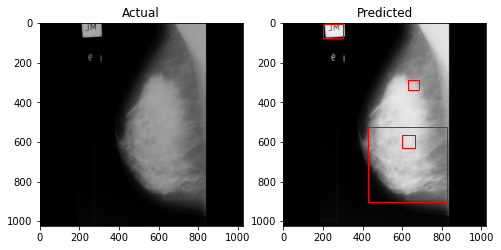

1 5


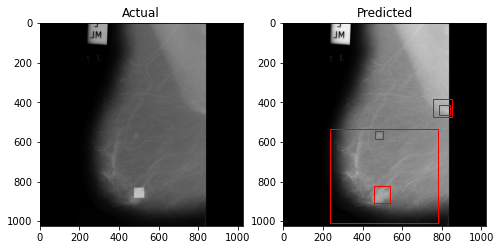

2 6


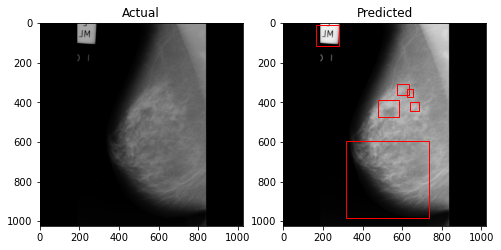

3 2


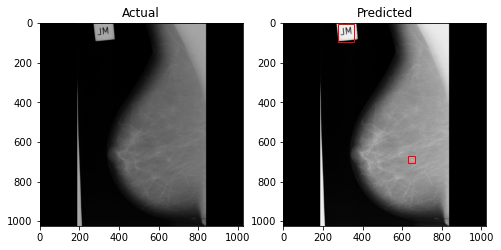

4 5


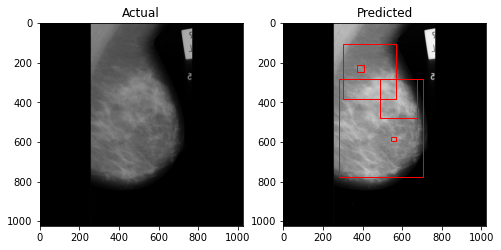

5 0


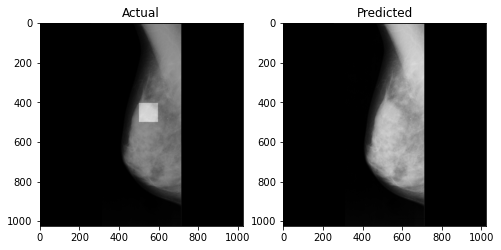

6 0


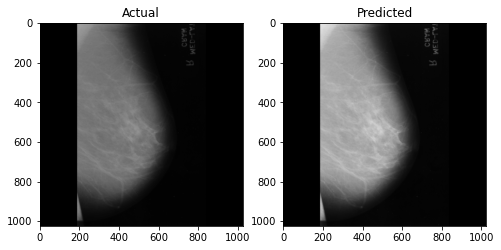

7 3


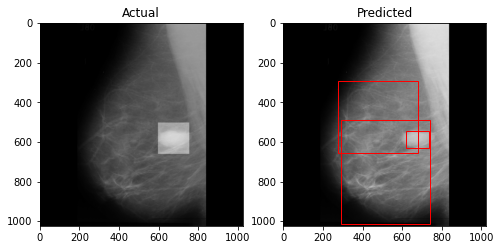

8 7


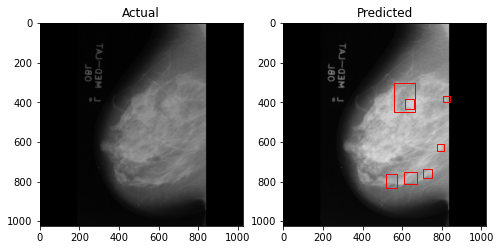

9 5


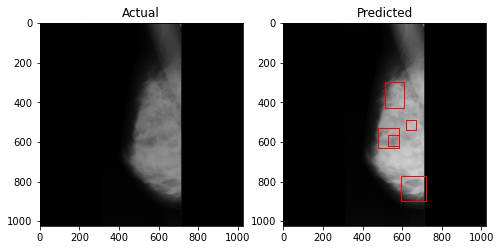

10 2


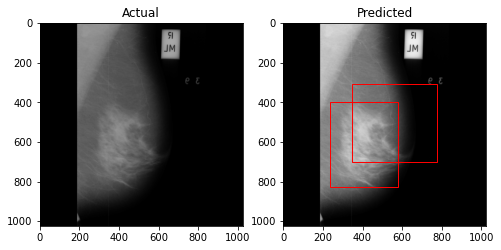

11 9


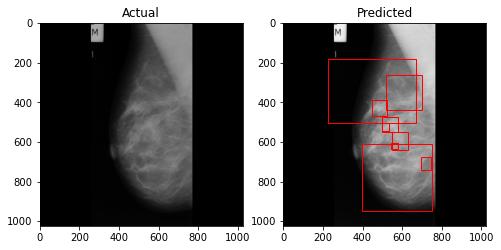

12 9


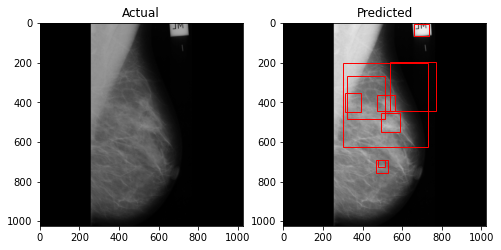

13 3


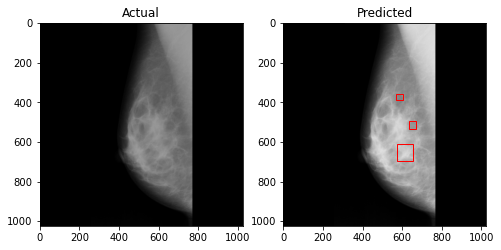

14 1


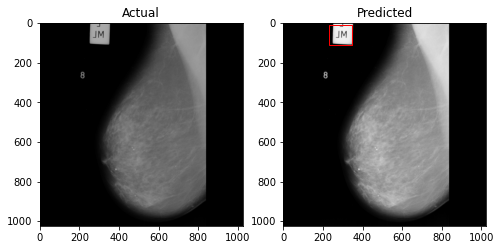

15 1


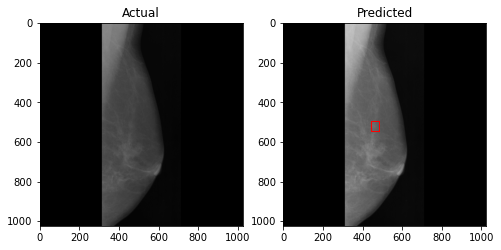

16 1


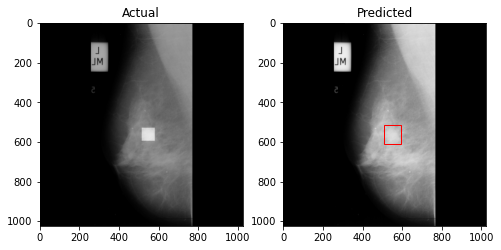

17 0


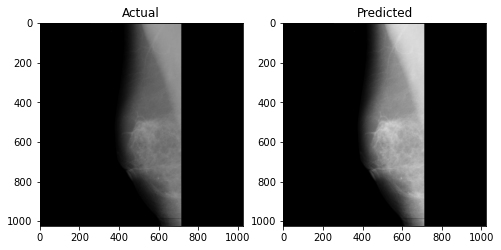

18 4


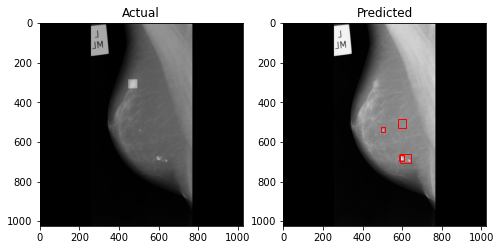

19 0


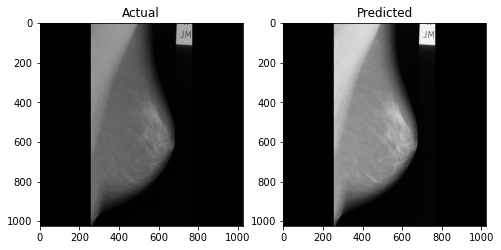

In [20]:
#Show plots
for i in range(20):
    plot_actual_vs_predicted(test_set, model_inf, cfg,n_start=i,n_images = 1)
